### 1. 환경설정
### 2. 데이터 살펴보기
### 3. 전처리
### 4. 모델링

## 1. 환경설정

In [35]:
import numpy as np 
import pandas as pd 
import os
import missingno as msno
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [36]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = os.path.join(data_dir, 'train.csv')
test_data_path = os.path.join(data_dir, 'test.csv')

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

## 2. 데이터 살펴보기

### 2.1 문제 정의
주택의 20가지 특징을 가지고 어떤 조건을 가진 집의 가격이 높고 낮은지를 예측하는 문제입니다.
train 데이터셋에는 다음 21가지(목적변수인 집의 가격 포함) 변수가 들어있습니다.

ID : 집을 구분하는 번호   
date : 집을 구매한 날짜   
price : 집의 가격(Target variable)   
bedrooms : 침실의 수   
bathrooms : 화장실의 수   
sqft_living : 주거 공간의 평방 피트(면적)   
sqft_lot : 부지의 평방 피트(면적)  
floors : 집의 층 수  
waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)  
view : 집이 얼마나 좋아 보이는지의 정도  
condition : 집의 전반적인 상태   
grade : King County grading 시스템 기준으로 매긴 집의 등급  
sqft_above : 지하실을 제외한 평방 피트(면적)  
sqft_basement : 지하실의 평방 피트(면적)  
yr_built : 지어진 년도  
yr_renovated : 집을 재건축한 년도  
zipcode : 우편번호  
lat : 위도  
long : 경도  
sqft_living15 : 2015년 기준 주거 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)  
sqft_lot15 : 2015년 기준 부지의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)   



### 2-2. 기본 정보 출력

In [37]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [38]:
print("train.csv. Shape: ",train.shape)
print("test.csv. Shape: ", test.shape)

train.csv. Shape:  (15035, 21)
test.csv. Shape:  (6468, 20)


train대 test 데이터가 약 5:2 비율을 보입니다. train 데이터셋의 컬럼은 총 21개인데 test 데이터셋에는 목적 변수가 빠졌으므로 20개만 있습니다.

In [39]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  object 
 2   price          15035 non-null  float64
 3   bedrooms       15035 non-null  int64  
 4   bathrooms      15035 non-null  float64
 5   sqft_living    15035 non-null  int64  
 6   sqft_lot       15035 non-null  int64  
 7   floors         15035 non-null  float64
 8   waterfront     15035 non-null  int64  
 9   view           15035 non-null  int64  
 10  condition      15035 non-null  int64  
 11  grade          15035 non-null  int64  
 12  sqft_above     15035 non-null  int64  
 13  sqft_basement  15035 non-null  int64  
 14  yr_built       15035 non-null  int64  
 15  yr_renovated   15035 non-null  int64  
 16  zipcode        15035 non-null  int64  
 17  lat            15035 non-null  float64
 18  long  

전체 15035개 데이터 중 결측치는 없는것으로 나옵니다.
date 컬럼은 object 타입이므로 모델에 바로 넣을 수 없습니다. 다음 절에서 상관계수를 보기 위해 date 컬럼을 연월 값을 int 타입으로 가지는 컬럼으로 대체합니다.

In [40]:
train['date'] = train['date'].str[:6].astype(int)
train['date']

0        201410
1        201502
2        201502
3        201406
4        201501
          ...  
15030    201410
15031    201503
15032    201405
15033    201502
15034    201410
Name: date, Length: 15035, dtype: int64

### 2-3. 변수 상관관계


price와의 상관계수가 높은 속성을 train 데이터셋을 이용해 찾아봅니다. id 속성은 가격과 관련없이 매긴것이므로 제외시킵니다.

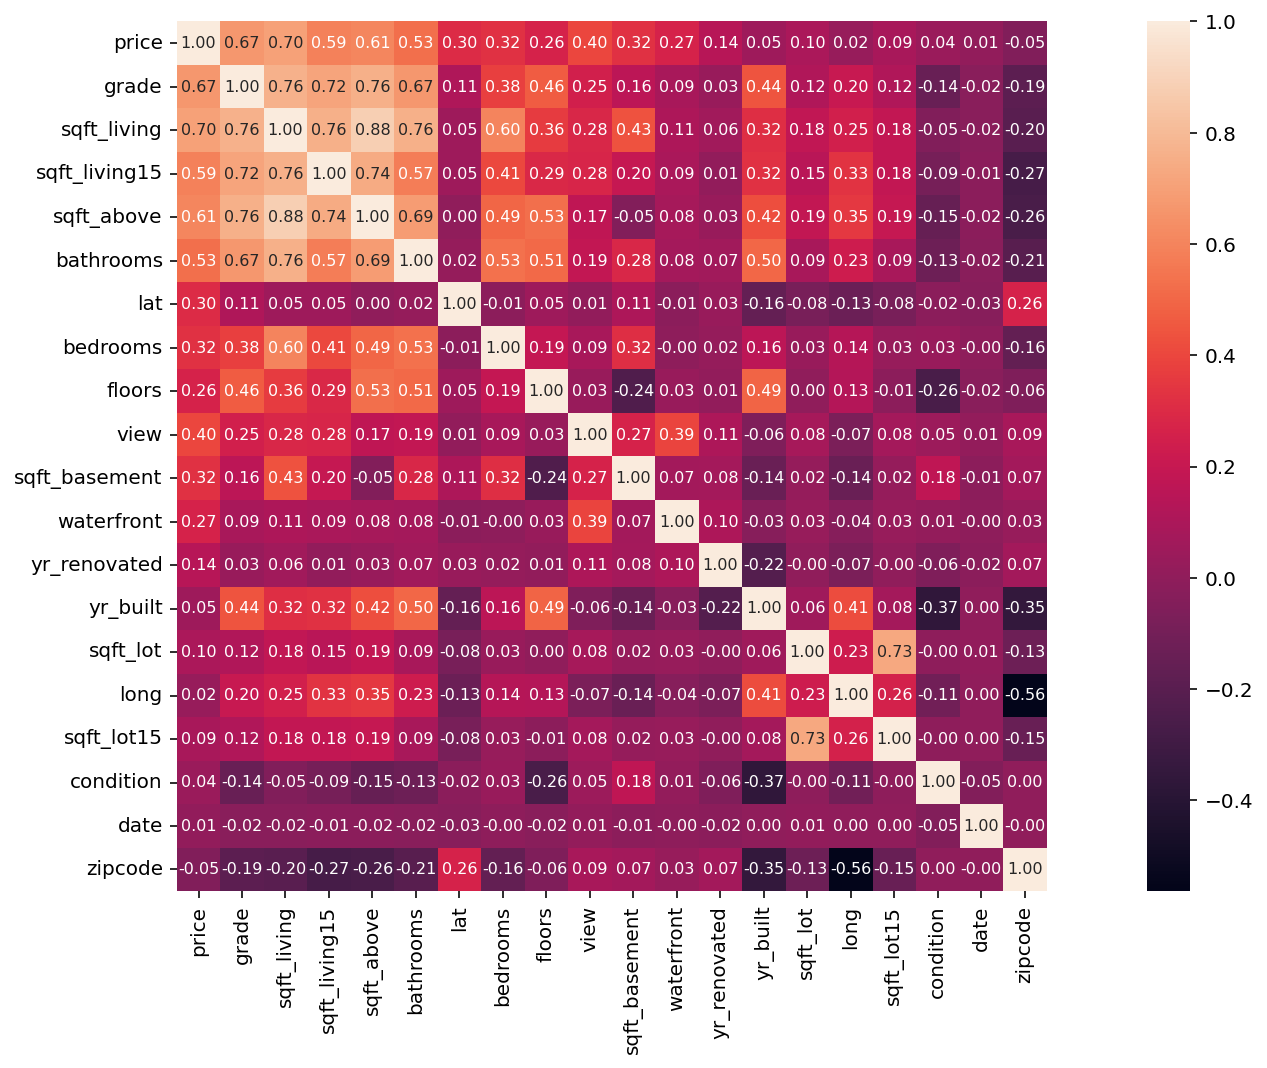

In [41]:
train_dup = train.copy()
train_dup.drop(columns=['id'], inplace=True)

k = 20
corrmat = train_dup.corr(method='spearman')
cols = corrmat.nlargest(k, 'price').index
cm = np.corrcoef(train_dup[cols].values.T)
f, ax = plt.subplots(figsize=(18, 8))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', 
                 annot_kws={'size': 8}, 
                 yticklabels=cols.values, xticklabels=cols.values)
plt.show()

#참고: https://www.kaggle.com/code/chocozzz/house-price-prediction-eda-updated-2019-03-12/notebook?scriptVersionId=11425534

grade, sqft_living, sqft_living15, sqft_above, bathrooms는 목적 변수 price와 0.5 이상의 강한 상관관계를 보입니다.

yr_built, long, conition, date, zipcode는 price와의 상관계수가 0.1이하로 매우 낮습니다.

## 3. 전처리

### 3.1 피처 스케일링

피처들의 분포를 살펴보고 적절한 스케일링을 적용하겠습니다.

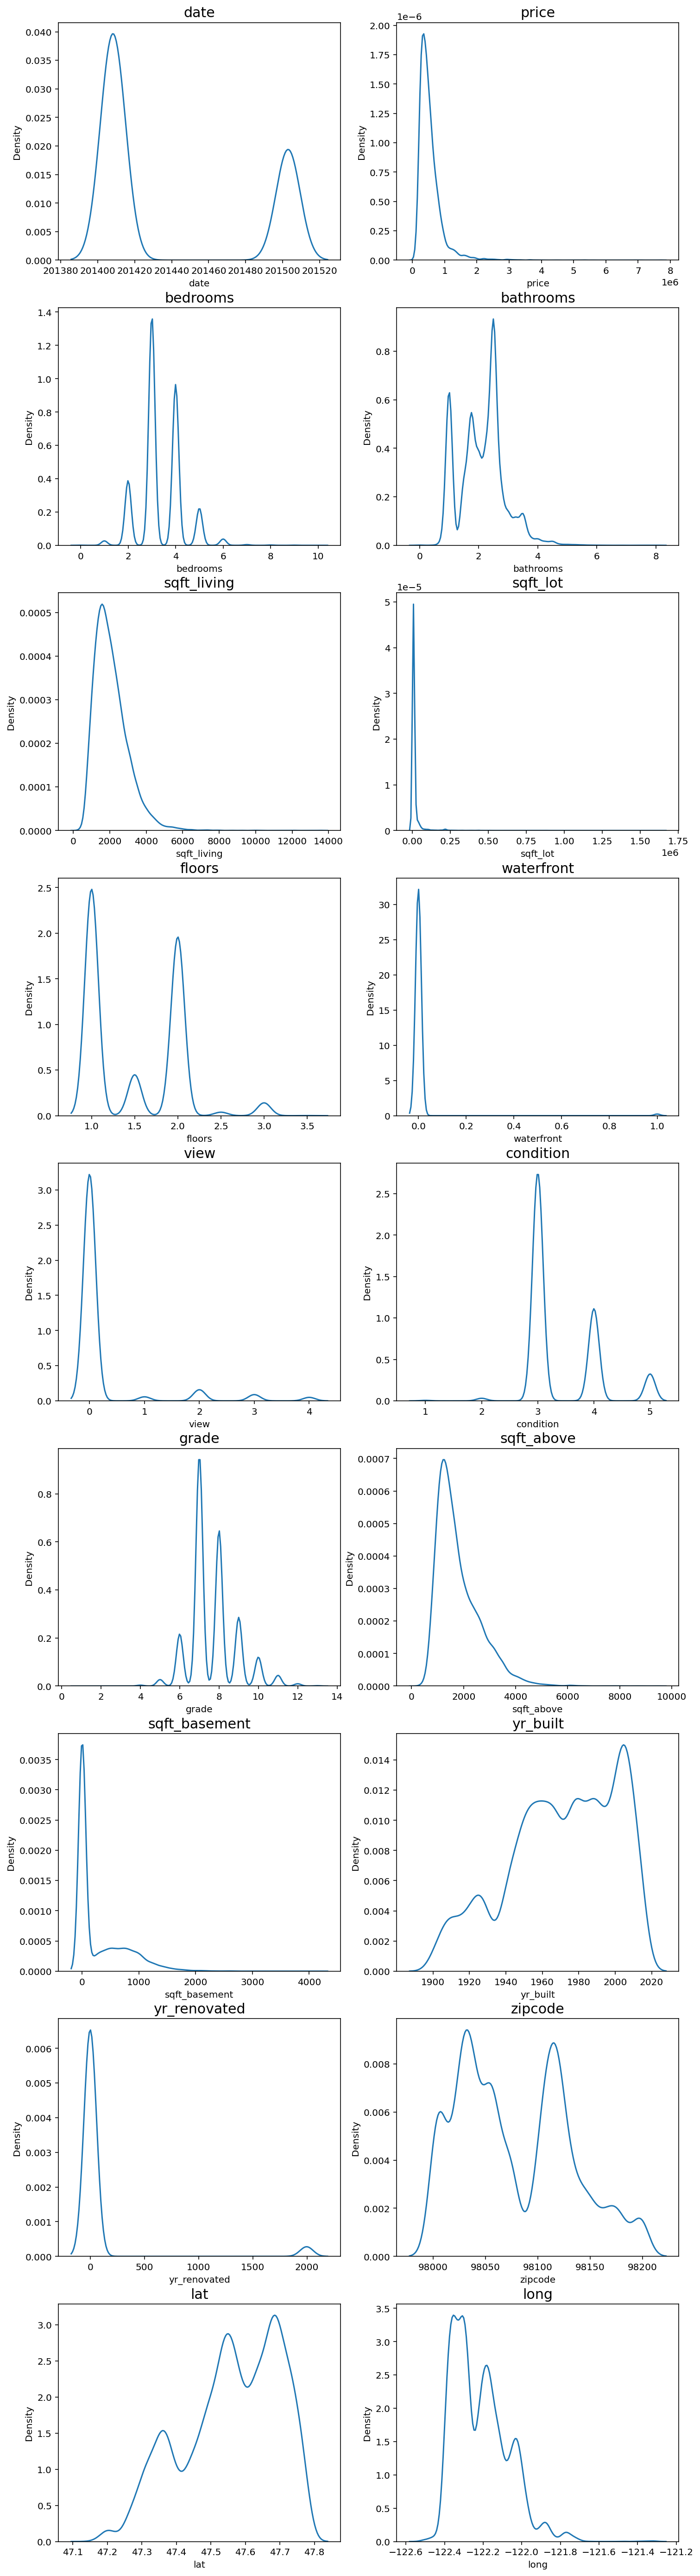

In [42]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))   

count = 1
columns = train.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=train[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

위 그래프 중에서 price, sqft_living, sqft_lot, sqft_above, sqft_basement, sqft_living15, sqft_lot15는 한쪽에 치우친 경향을 보입니다. 이 변수들에는 로그 변환을 적용하겠습니다. 

In [43]:
skew_columns = ['price', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    train[c] = np.log1p(train[c].values)

아래는 변수들이 로그변환된 후 대칭에 가까워진 모습입니다.

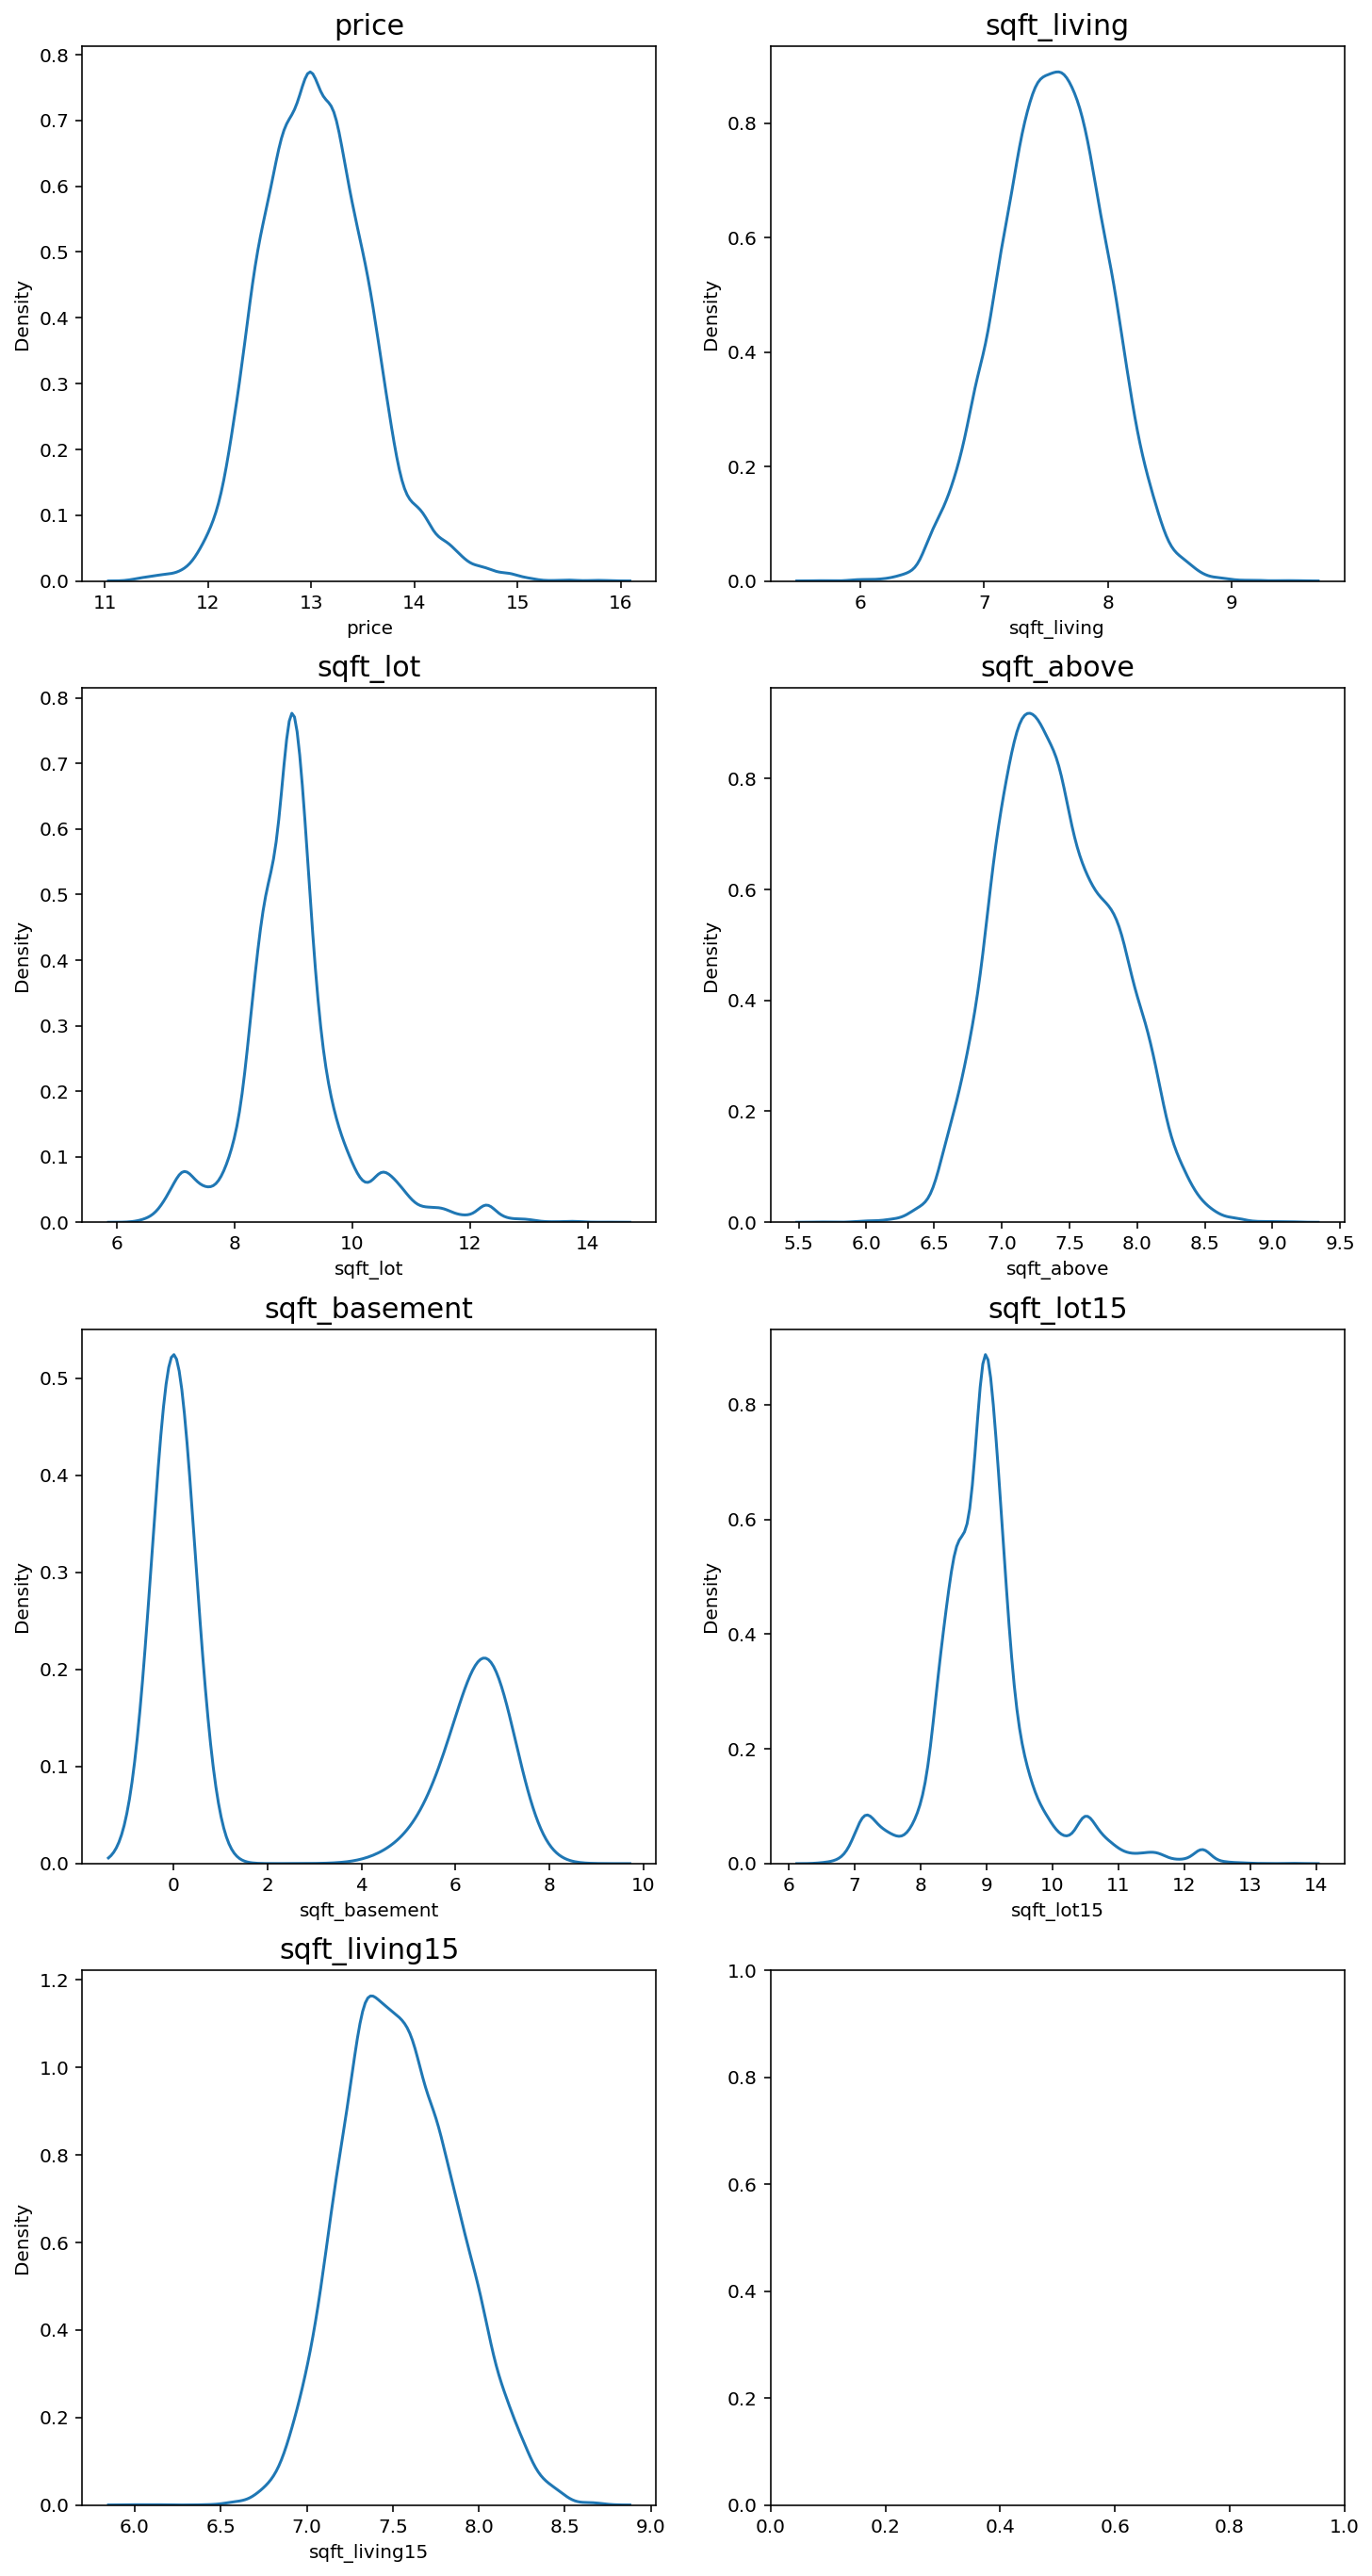

In [44]:
fig, ax = plt.subplots(4, 2, figsize=(12, 24))

count = 0
for row in range(4):
    for col in range(2):
        if count == 7:
            break
        sns.kdeplot(data=train[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

In [45]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  int64  
 2   price          15035 non-null  float64
 3   bedrooms       15035 non-null  int64  
 4   bathrooms      15035 non-null  float64
 5   sqft_living    15035 non-null  float64
 6   sqft_lot       15035 non-null  float64
 7   floors         15035 non-null  float64
 8   waterfront     15035 non-null  int64  
 9   view           15035 non-null  int64  
 10  condition      15035 non-null  int64  
 11  grade          15035 non-null  int64  
 12  sqft_above     15035 non-null  float64
 13  sqft_basement  15035 non-null  float64
 14  yr_built       15035 non-null  int64  
 15  yr_renovated   15035 non-null  int64  
 16  zipcode        15035 non-null  int64  
 17  lat            15035 non-null  float64
 18  long  

목적변수인 price 특성은 분리합니다.

In [46]:
y = train['price']
del train['price']

예측에 도움되지 않는 id를 제거합니다.

In [47]:
del train['id']
del test['id']

test 데이터셋에 있는 변수들도 마찬가지로 전처리해줍니다.

In [48]:
test['date'] = test['date'].str[:6].astype(int)
skew_columns = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']
for c in skew_columns:
    test[c] = np.log1p(test[c].values)

### 3.2  특성 엔지니어링

방 수, 면적은 집값과 관련이 높고 총합값이 주택시장에서 유의미하므로 총합값을 피처로 추가합니다.  

In [49]:
for df in [train,test]:
    df['total_rooms'] = df['bedrooms'] + df['bathrooms']

## 4. 모델링

예측은 XGBoost와 LGBM 두 모델을 사용합니다. 각각의 모델의 하이퍼파라미터를 직접 튜닝하고 앙상블으로 최종 결과를 도출합니다.

In [15]:
random_state=2020
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))
X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)


### XGBoost

In [31]:
model1 = XGBRegressor(max_depth=4, learning_rate=0.05, n_estimators=400, random_state=random_state)
model1.fit(X_train, y_train)
y_pred1 = model1.predict(X_test)
print('XGBoost', rmse(y_test, y_pred1))

XGBoost 111037.10063667898


In [32]:
model1 = XGBRegressor(max_depth=6, learning_rate=0.05, n_estimators=400, random_state=random_state)
model1.fit(X_train, y_train)
y_pred1 = model1.predict(X_test)
print('XGBoost', rmse(y_test, y_pred1))

XGBoost 106525.52455072527


In [57]:
model1 = XGBRegressor(max_depth=8, learning_rate=0.05, n_estimators=400, random_state=random_state)
model1.fit(X_train, y_train)
y_pred1 = model1.predict(X_test)
print('XGBoost', rmse(y_test, y_pred1))

XGBoost 106200.6279692906


In [18]:
model1 = XGBRegressor(max_depth=10, learning_rate=0.05, n_estimators=400, random_state=random_state)
model1.fit(X_train, y_train)
y_pred1 = model1.predict(X_test)
print('XGBoost', rmse(y_test, y_pred1))

XGBoost 109170.9367746182


max_depth=8, learning_rate=0.05, n_estimators=400을 채택합니다.

### LGBM

In [23]:
model2 = LGBMRegressor(max_depth=-1, n_estimators=300, random_state=random_state)
model2.fit(X_train, y_train)
y_pred2 = model2.predict(X_test)
print('LGBM', rmse(y_test, y_pred2))

LGBM 109307.96871961602


In [25]:
model2 = LGBMRegressor(n_estimators=400, random_state=random_state)
model2.fit(X_train, y_train)
y_pred2 = model2.predict(X_test)
print('LGBM', rmse(y_test, y_pred2))

LGBM 109220.4985511342


In [20]:
model2 = LGBMRegressor(n_estimators=500, random_state=random_state)
model2.fit(X_train, y_train)
y_pred2 = model2.predict(X_test)
print('LGBM', rmse(y_test, y_pred2))

LGBM 109294.35750236592


In [21]:
model2 = LGBMRegressor(n_estimators=600, random_state=random_state)
model2.fit(X_train, y_train)
y_pred2 = model2.predict(X_test)
print('LGBM', rmse(y_test, y_pred2))

LGBM 109458.5377457677


In [24]:
model2 = LGBMRegressor(n_estimators=700, random_state=random_state)
model2.fit(X_train, y_train)
y_pred2 = model2.predict(X_test)
print('LGBM', rmse(y_test, y_pred2))

LGBM 109626.39893240234


LGBM에는 n_estimators=400을 적용합니다.

### 튜닝한 하이퍼파라미터 적용

In [55]:
model1 = XGBRegressor(max_depth=8, learning_rate=0.05, n_estimators=400, random_state=random_state)
model1.fit(X_train, y_train)
y_pred1 = model1.predict(X_test)

In [56]:
model2 = LGBMRegressor(n_estimators=400, random_state=random_state)
model2.fit(X_train, y_train)
y_pred2 = model2.predict(X_test)

### 결과 저장

블렌딩 비율은 0.5:0.5를 채택합니다.

In [59]:
from datetime import datetime
now = int(datetime.now().timestamp())
model1 = XGBRegressor(max_depth=8, learning_rate=0.05, n_estimators=400, random_state=random_state)
model1.fit(train, y)
y_pred1 = model1.predict(test)
model2 = LGBMRegressor(n_estimators=400, random_state=random_state)
model2.fit(train, y)
y_pred2 = model2.predict(test)

output_path = '.'
model_name = 'esb'

pred_esb = 0.5 * np.expm1(y_pred1) + 0.5 * np.expm1(y_pred2)

data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = os.path.join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)

submission['price'] = pred_esb
submission.head()

submission_csv_path = f'{output_path}/submission_{model_name}_{now}.csv'
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

./submission_esb_1663942374.csv


### 제출 결과

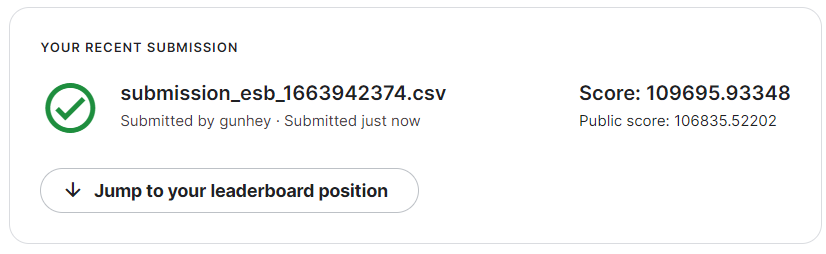

# 회고

어려웠던 점   
* 최적의 하이퍼파라미터를 찾기 위해서 Grid Search를 시도했습니다. 그런데 넓은 파라미터범위를 GridSearchCV 한번 호출으로 탐색하기에는 소요시간이 너무 긴데다가 XGB의 하이퍼파라미터를 찾을때, 메모리 과다사용으로 프로세스가 죽는 일이 발생했습니다. 단독으로 실행하면 돌아가는 하이퍼파라미터도 탐색을 못하는 상황을 보며 수동으로 튜닝하는 한편 이유를 알아보았습니다.  
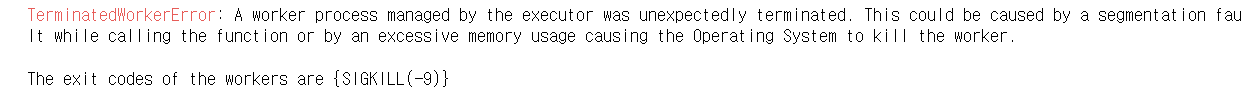
   
이유는 세 가지가 있었습니다. GridSearchCV의 인자 n_jobs, XGBoost의 인자 n_estimators와 max_depth를 높게 준것입니다. n_jobs가 높으면 CPU 코어마다 접근할 데이터셋을 메모리에 복제해놓아야해서 메모리 사용량이 늘어납니다. n_estimators는 의사결정트리 기반 모델에서 의사결정트리 개수입니다. max_depth는 의사결정트리의 최대 깊이를 뜻합니다. 하나의 XGB 모델에 들어가는 의사결정트리 깊이가 깊고, 개수가 많고, 이런 모델을 두 코어에서 병렬실행할수있게 모델도 여러개, 데이터셋도 두개가 메모리에 들어가 있어서 초과가 난것입니다. 




커널 정지시
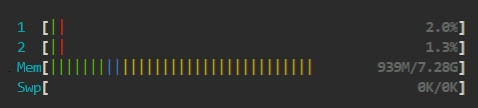   
패키지 로드
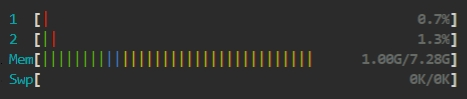
n_jobs=1 서치 시작시
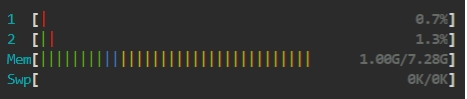
n_jobs=2 서치 시작시
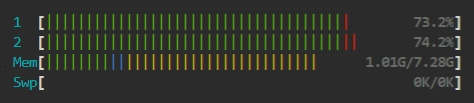
n_jobs=4 서치 시작시
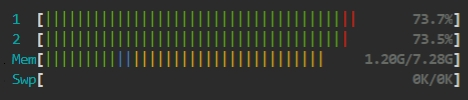
n_jobs=4 서치 지속중, max_depth=8, n_estimator=1500인 케이스
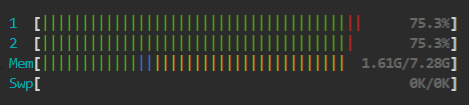
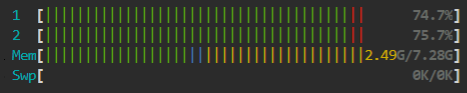

* 랜덤시드도 튜닝 대상이 된다는 걸 뒤늦게 알았습니다. 랜덤시드에 따라 성능이 매우 큰 폭으로 변해서 놀랐습니다...
* 데이터를 파악하고 머신러닝으로 문제를 해결하는 과정에 대해 이해도가 높아져서 뿌듯합니다. 
* 이번 노드는 긴 기간 띄엄띄엄 했더니 까먹은것이 많아 시간 낭비가 컸습니다.다른 exploration 노드는 늦어도 이틀안에 다 끝내야겠습니다.